# TITLE

## 1. Import delle librerie e caricamento dei dati

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importing dataset
file_path_bin = "../../data/processed/wifi_fingerprinting_dataset_binarized.csv"
file_path_norm = "../../data/processed/wifi_fingerprinting_dataset_normalized.csv"
file_path_0 = "../../data/raw//wifi_fingerprinting_dataset.csv"
file_path_200 = "../../data/raw/wifi_fingerprinting_dataset_cut_200_ap27.csv"
file_path_400 = "../../data/processed/wifi_fingerprinting_dataset_cut_400_ap22.csv"


df = pd.read_csv(file_path_bin, sep=',')

# Filling NaN values with -200 RSSI: AP is too far away from the current reference point and no signals could be heard from it
# With dataset_binarized and dataset_normalized all RSSI are already filled
# and no values will be added
df.fillna(-200, inplace=True)

# Creating different dataframes based on room situation: empty, crowded and hybrid (a mix of the two)
# For each dataframe "Situazione" column is dropped
df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])
df_hybrid = df.drop(columns=["Situazione"])

### 1-1. Analisi esplorativa dei dati

## 2. Creazione dei modelli

In [4]:
# Split the data into training and test sets
# 70% training set, 30% test set
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]


    # When splitting the data, we set:
        # random_state: a seed to get the same train/test split every time --> keeping it fixed allows to compare the results obtained for all the dataframe
        # stratify: ensures that the train, validation, and test sets maintain the same class distribution as the original dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

X_train_empty, X_test_empty, y_train_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_test_crowded, y_train_crowded, y_test_crowded = split_data(df_crowded)
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = split_data(df_hybrid)

# Display the number of samples in each split for all datasets
def print_split_info(name, X_train, X_test):
    print(f"\n{name} dataset:")
    print(f"  Train set:      {X_train.shape[0]} samples")
    print(f"  Test set:       {X_test.shape[0]} samples")

print_split_info("Empty", X_train_empty, X_test_empty)
print_split_info("Crowded", X_train_crowded, X_test_crowded)
print_split_info("Hybrid", X_train_hybrid, X_test_hybrid)


Empty dataset:
  Train set:      338 samples
  Test set:       146 samples

Crowded dataset:
  Train set:      349 samples
  Test set:       150 samples

Hybrid dataset:
  Train set:      688 samples
  Test set:       295 samples


## 3. Addestramento dei modelli e tuning dei parametri

In [ ]:
# Grid Search with Cross-Validation
# Parameters tuning for empty, crowded and hybrid situations is calculated by GridSearchCV
# GridSearchCV iterates on all different parameters given and elaborate wich one give the best results based on a certain metric

def find_best_knn(X_train, y_train):
    param_grid = {
        'n_neighbors': range(3, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'brute'], #'kd_tree'
        'metric': ['euclidean', 'manhattan'], #'minkowski'
    }

    knn = KNeighborsClassifier()

    # StratifiedKFold: splits data into k folds, but ensures each fold has the same distribution of class labels
    grid_search = GridSearchCV(knn, param_grid, cv=StratifiedKFold(n_splits=4), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_, grid_search.best_score_

best_params_empty, acc_empty = find_best_knn(X_train_empty, y_train_empty)
best_params_crowded, acc_crowded = find_best_knn(X_train_crowded, y_train_crowded)
best_params_hybrid, acc_hybrid = find_best_knn(X_train_hybrid, y_train_hybrid)

print(f"Empty -> Best params: {best_params_empty}, Best accuracy: {acc_empty:.4f}")
print(f"Crowded -> Best params: {best_params_crowded}, Best accuracy: {acc_crowded:.4f}")
print(f"Hybrid -> Best params: {best_params_hybrid}, Best accuracy: {acc_hybrid:.4f}")

Empty -> Best params: {'algorithm': 'brute', 'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}, Best accuracy: 0.9793
Crowded -> Best params: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}, Best accuracy: 0.9340
Hybrid -> Best params: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}, Best accuracy: 0.9302


## 4. Risultati

In [6]:
# Function to evaluate the model on the test set and display summary metrics

def evaluate_on_test_summary(X_train, y_train, X_test, y_test, best_params, label, label2):
    # Use the best parameters found during grid search
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    type_dict = {
        "Train Model": label,
        "Test Model": label2,
        "Neighbors": best_params['n_neighbors'],
        "Weights": best_params['weights'],
        "Algorithm": best_params['algorithm'],
        "Metric": best_params['metric'],        
    }
    metric_dict = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    return type_dict, metric_dict



em = "Empty"
cr = "Crowded"
hy = "Hybrid"
results = []
type_data = []
metric_data = []

# Evaluate on the test set with the best parameters for each dataset
# Introducing Cross testing:
#   we want to evaluate the quality of the model by testing a certain situation on a model trained on a different situation

#        |  Empty (em)  |  Crowded (cr)  |  Hybrid (hy)  |
# -------|--------------|----------------|---------------|
# Empty  |     em/em    |      em/cr     |     em/hy     |
# Crowded|     cr/em    |      cr/cr     |     cr/hy     |
# Hybrid |     hy/em    |      hy/cr     |     hy/hy     |

results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty, em, em))
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty, em, cr))
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty, em, hy))

results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded, cr, em))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded, cr, cr))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded, cr, hy))

results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid, hy, em))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid, hy, cr))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid, hy, hy))



for result in results:
    type_dict, metric_dict = result
    type_data.append(type_dict)
    metric_data.append(metric_dict)

type_df = pd.DataFrame(type_data)
metric_df = pd.DataFrame(metric_data)

print("\nSummary of test set results (Model Parameters):")
print(type_df.round(3))

print("\nSummary of test set results (Metrics):")
print(metric_df.round(3))



Summary of test set results (Model Parameters):
  Train Model Test Model  Neighbors   Weights  Algorithm     Metric
0       Empty      Empty          6  distance      brute  manhattan
1       Empty    Crowded          6  distance      brute  manhattan
2       Empty     Hybrid          6  distance      brute  manhattan
3     Crowded      Empty         15  distance  ball_tree  manhattan
4     Crowded    Crowded         15  distance  ball_tree  manhattan
5     Crowded     Hybrid         15  distance  ball_tree  manhattan
6      Hybrid      Empty         16   uniform      brute  euclidean
7      Hybrid    Crowded         16   uniform      brute  euclidean
8      Hybrid     Hybrid         16   uniform      brute  euclidean

Summary of test set results (Metrics):
   Accuracy  Precision  Recall  F1-score
0     0.932      0.935   0.932     0.931
1     0.813      0.808   0.813     0.797
2     0.912      0.912   0.912     0.909
3     0.904      0.913   0.904     0.904
4     0.887      0.884   0


Confusion matrices:


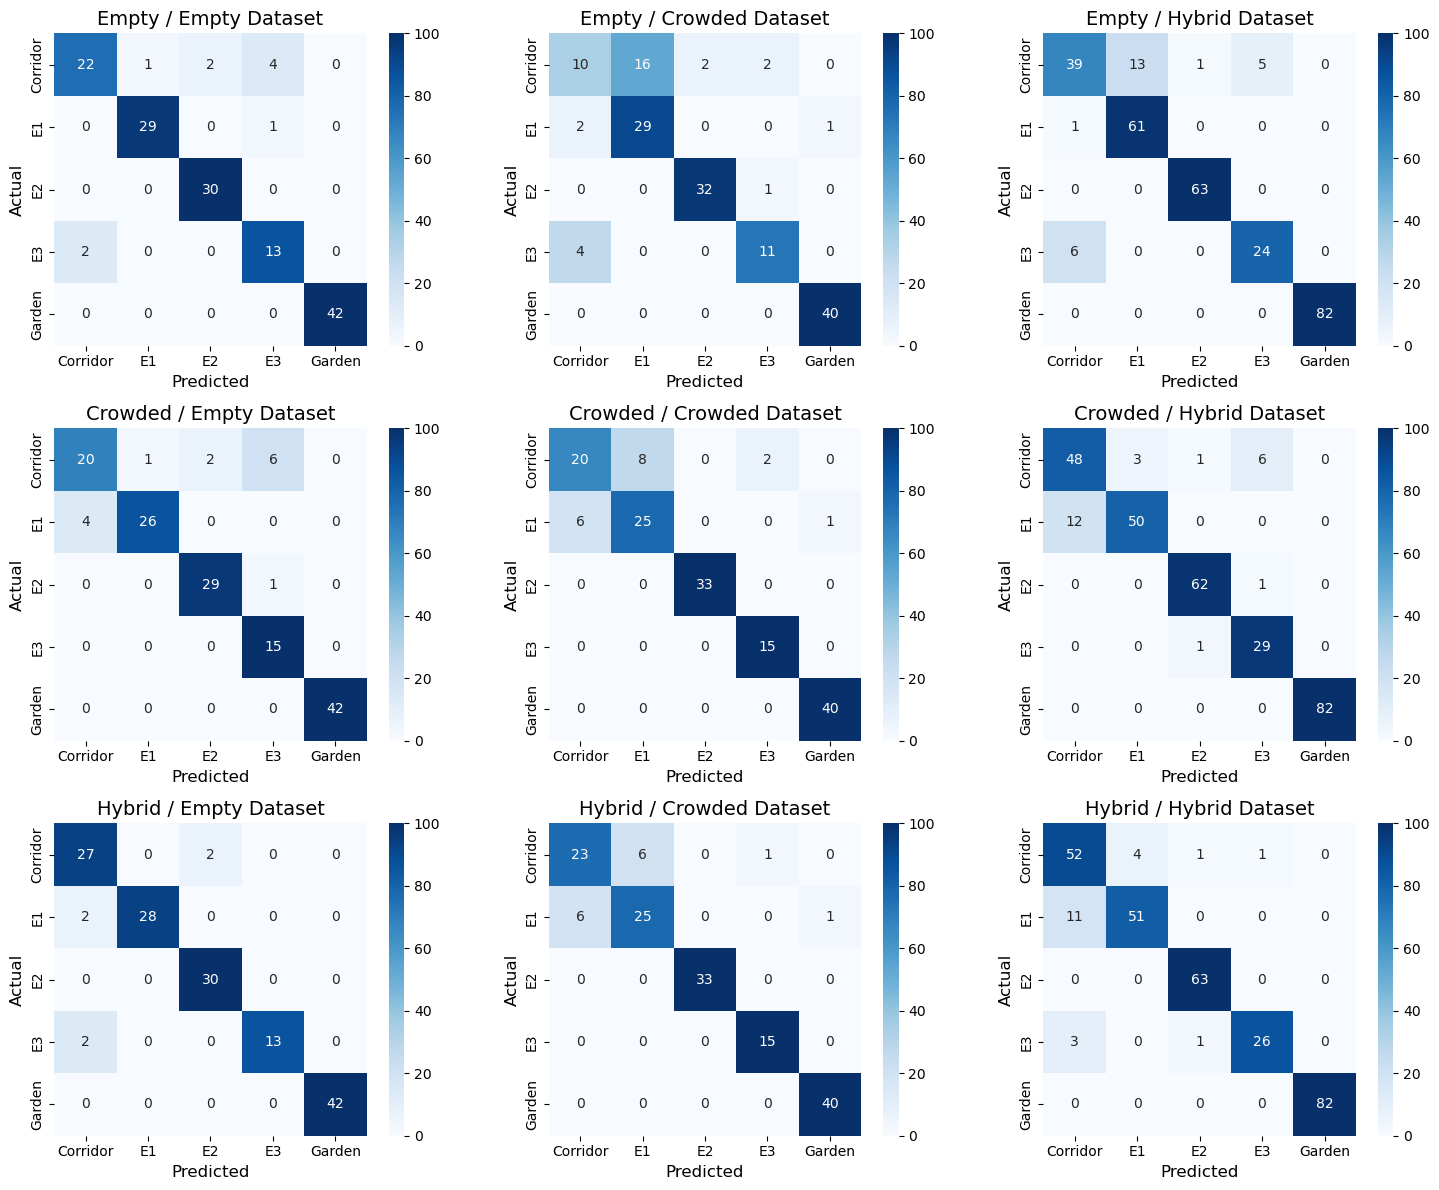

In [7]:
# NOTE: we fit and test again the model with the best params just because it is not a computationally intensive task
    # in bigger models it is wise to optimize this process

# Plot confusion matrices for the best models on a 3x3 grid
def plot_conf_matrices():
    datasets = [
        (f"{em} / {em}", X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_params_empty),
        (f"{em} / {cr}", X_train_empty, y_train_empty, X_test_crowded, y_test_crowded, best_params_empty),
        (f"{em} / {hy}", X_train_empty, y_train_empty, X_test_hybrid, y_test_hybrid, best_params_empty),

        (f"{cr} / {em}", X_train_crowded, y_train_crowded, X_test_empty, y_test_empty, best_params_crowded),
        (f"{cr} / {cr}", X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_params_crowded),
        (f"{cr} / {hy}", X_train_crowded, y_train_crowded, X_test_hybrid, y_test_hybrid, best_params_crowded),

        (f"{hy} / {em}", X_train_hybrid, y_train_hybrid, X_test_empty, y_test_empty, best_params_hybrid),
        (f"{hy} / {cr}", X_train_hybrid, y_train_hybrid, X_test_crowded, y_test_crowded, best_params_hybrid),
        (f"{hy} / {hy}", X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_params_hybrid),

    ]


    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15,12))

    for ax, (label, X_train, y_train, X_test, y_test, best_params) in zip(axes.flatten(), datasets):

        model = KNeighborsClassifier(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Ensure all class labels are represented
        class_labels = sorted(np.unique(np.concatenate((y_train, y_test))))  
        # Generate the confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        # Normalize row-wise for percentage-based color scaling
        cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
        cm_percentage = np.nan_to_num(cm_percentage)  # Handle div by zero
        # Plot confusion matrix (color represents percentage, text is raw count)
        sns.heatmap(cm_percentage, annot=cm, square=1, fmt="d", cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels, ax=ax, cbar=True)

        ax.set_title(f"{label} Dataset", fontsize=14)  # Increase font size
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("Actual", fontsize=12)

    # Hide any empty subplots if datasets < 9
    for i in range(len(datasets), rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()


# Display the confusion matrices
print("\nConfusion matrices:")
plot_conf_matrices()